<a href="https://colab.research.google.com/github/alupo933/Python-Work-for-Bootcamp/blob/main/Copy_of_Intro_to_Gradient_Boosting_Assignment_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Gradient Boosting

![gradient boosting image](https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG)

Image thanks to [Geeks for Geeks](https://www.geeksforgeeks.org/ml-gradient-boosting/)

In this assignment you will:
1. import and prepare a dataset for modeling
2. test and evaluate 3 different boosting models and compare the fit times of each.
3. tune the hyperparameters of the best model to reduce overfitting and improve performance.

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn import set_config
set_config(display='diagram')

In this assignment you will be working with census data.  Your goal is to predict whether a person will make more or less than $50k per year in income.

The data is available [here](https://drive.google.com/file/d/1drlRzq-lIY7rxQnvv_3fsxfIfLsjQ4A-/view?usp=sharing)

#Create a classification Function:

In [77]:
import sklearn.metrics as metrics
def evaluate_classification(model, X, y_true, classes=None, normalize='true',
                            cmap="Blues", label="Test Data"): 

    ## Get Predictions
    y_pred = model.predict(X)
    
    ## Classification Report / Scores 
    dashes = '---'*20
    print(dashes)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print(dashes)
    
    print(metrics.classification_report(y_true,y_pred,
                                        target_names=classes))
    

    ## Plot a confusion matrix
    cm = metrics.confusion_matrix(y_true,y_pred,normalize=normalize,)
    ax = sns.heatmap(cm, annot=True,square=True,cmap=cmap)

    if classes != None:
        ## Label classes
        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes,rotation=0)

    ## Add axis labels & title
    ax.set_ylabel('True Classes')
    ax.set_xlabel('Predicted Classes')
    ax.set_title('Confusion Matrix');
    plt.show()
    

In [60]:
  filename = '/content/drive/MyDrive/Coding Dojo Data Science Boot Camp/Excel Files/census_income - census_income.csv'
  df = pd.read_csv(filename)
  df.head() 

,Unnamed: 0,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Prepare your dataset for modeling.

Remember to: 
1. Check for missing data, bad data, and duplicates.
2. Check your target class balance.
3. Perform your validation split
4. Create a preprocessing pipeline to use with your models.
5. Fit and evaluate your models using pipelines

In [61]:
# Check for duplicates
df.duplicated().sum()

0

There are no duplicates

In [62]:
# Check for missing data
df.isnull().sum()

Unnamed: 0        0
age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income-class      0
dtype: int64

There is no missing data

In [63]:
# Check for bad data
df.describe()

,Unnamed: 0,age,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,16280.000000,38.581647,1077.648844,87.303830,40.437456
std,9399.695394,13.640433,7385.292085,402.960219,12.347429
min,0.000000,17.000000,0.000000,0.000000,1.000000
25%,8140.000000,28.000000,0.000000,0.000000,40.000000
50%,16280.000000,37.000000,0.000000,0.000000,40.000000
75%,24420.000000,48.000000,0.000000,0.000000,45.000000
max,32560.000000,90.000000,99999.000000,4356.000000,99.000000


In [64]:
df['capital-gain'].value_counts()

0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
1111         1
2538         1
22040        1
4931         1
5060         1
Name: capital-gain, Length: 119, dtype: int64

In [65]:
df.dtypes

Unnamed: 0         int64
age                int64
workclass         object
education         object
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income-class      object
dtype: object

In [66]:
df.head()

,Unnamed: 0,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [67]:
# Check the target balance
df['income-class'].value_counts(normalize=True)

<=50K    0.75919
>50K     0.24081
Name: income-class, dtype: float64

In [68]:
# Drop unneccessary Columns
df.drop(columns= 'Unnamed: 0', inplace=True)
# Binarize target column
df['income-class']= df['income-class'].map({'<=50K': 1, '>50K': 0})
# Save X data
X = df.drop(columns='income-class')
# Encode the target
y = df['income-class']

In [69]:
# Perform validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [70]:
# Create a preprocessing pipeline to use with model
# Instantiate model and fit on training set
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')
scaler = StandardScaler()
ohe_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [71]:
# Make tuples
number_tuple = (scaler, num_selector)
category_tuple = (ohe_encoder, cat_selector)

In [72]:
# Make preprocesseor
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd16ebb8d10>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd16ebb8dd0>)])

# eXtreme Gradient Boosting
We are going to compare both metrics and fit times for our models.  Notice the 'cell magic' in the top of the cell below.  By putting `%%time` at the top of a notebook cell, we can tell it to output how long that cell took to run.  We can use this to compare the speed of each of our different models.  Fit times can be very important for models in deployment, especially with very large dataset and/or many features.

Instantiate an eXtreme Gradient Boosting Classifier (XGBClassifier) below, fit it, and print out a classification report.  Take note of the accuracy, recall, precision, and f1-score, as well as the run time of the cell to compare to our next models.

In [73]:
%%time
# Instantiate the model
xgboost = XGBClassifier()
# Make a pipeline of the model
xgb_pipe = make_pipeline(preprocessor, xgboost)


CPU times: user 251 µs, sys: 0 ns, total: 251 µs
Wall time: 432 µs


In [74]:
%%time 
# Fit the model
xgb_pipe.fit(X_train, y_train)

CPU times: user 5.57 s, sys: 41.3 ms, total: 5.61 s
Wall time: 5.53 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd16ebb8d10>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd16ebb8dd0>)])),
                ('xgbclassifier', XGBClassifier())])

In [75]:
%%time
# Get Predictions for training and testing data to check the metric functions
xgb_train_predict = xgb_pipe.predict(X_train)
xgb_test_predict = xgb_pipe.predict(X_test)

CPU times: user 226 ms, sys: 1.91 ms, total: 228 ms
Wall time: 232 ms


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGB Training Data (Classes-Incuded)
------------------------------------------------------------
              precision    recall  f1-score   support

        >50K       0.81      0.57      0.67      5914
       =<50K       0.87      0.96      0.91     18506

    accuracy                           0.86     24420
   macro avg       0.84      0.76      0.79     24420
weighted avg       0.86      0.86      0.86     24420



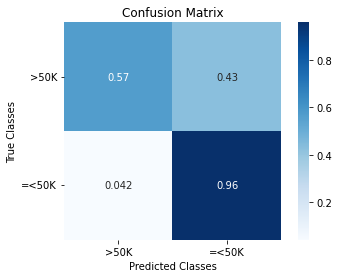

CPU times: user 1.36 s, sys: 49.3 ms, total: 1.41 s
Wall time: 1.54 s


In [81]:
%%time
# XGB Training Model Evaluation
target_names = ['>50K', '=<50K']
evaluate_classification(xgb_pipe,X_train, y_train, classes=target_names,
                        label='XGB Training Data (Classes-Incuded)')

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGB Testing Data (Classes-Included)
------------------------------------------------------------
              precision    recall  f1-score   support

        >50K       0.81      0.57      0.67      1927
       =<50K       0.88      0.96      0.92      6214

    accuracy                           0.87      8141
   macro avg       0.84      0.77      0.79      8141
weighted avg       0.86      0.87      0.86      8141



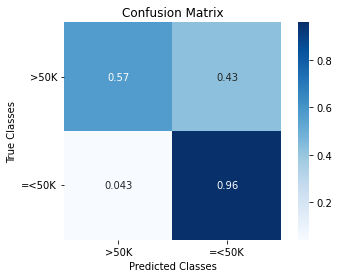

CPU times: user 843 ms, sys: 133 ms, total: 976 ms
Wall time: 2.09 s


In [82]:
%%time 
# XGB Testing Model Evaluation
evaluate_classification(xgb_pipe, X_test, y_test, classes=target_names,
                        label='XGB Testing Data (Classes-Included)')

Which target class is your model better at predicting?  Is it significantly overfit?

# More Gradient Boosting

Now fit and evaluate a Light Gradient Boosting Machine and a the Scikit Learn (sklearn) gradient boost model.  Remember to use the `%%time` cell magic command to get the run time.

## LightGBM

In [83]:
%%time
# Instantiate the model 
lgboost = LGBMClassifier()

# Make a pipeline for the LGBM
lgb_pipe = make_pipeline(preprocessor, lgboost)

CPU times: user 117 µs, sys: 3 µs, total: 120 µs
Wall time: 125 µs


In [84]:
%%time
# Fit the model
lgb_pipe.fit(X_train, y_train)

CPU times: user 936 ms, sys: 21.1 ms, total: 957 ms
Wall time: 1.17 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd16ebb8d10>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd16ebb8dd0>)])),
                ('lgbmclassifier', LGBMClassifier())])

In [85]:
%%time
# predict the model
lgb_train_predict = lgb_pipe.predict(X_train)
lgb_test_predict = lgb_pipe.predict(X_test)

CPU times: user 442 ms, sys: 3.86 ms, total: 446 ms
Wall time: 511 ms


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: LGBModel Training Data (Classes Included)
------------------------------------------------------------
              precision    recall  f1-score   support

        >50K       0.81      0.69      0.75      5914
       =<50K       0.91      0.95      0.93     18506

    accuracy                           0.89     24420
   macro avg       0.86      0.82      0.84     24420
weighted avg       0.88      0.89      0.88     24420



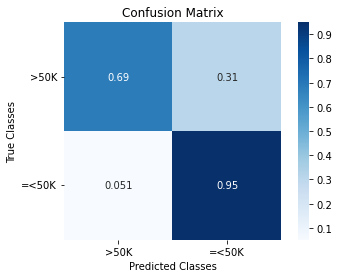

CPU times: user 1.53 s, sys: 62.5 ms, total: 1.6 s
Wall time: 1.54 s


In [87]:
%%time
# Evalute the model
# LGBM Training Model evaluation
evaluate_classification(lgb_pipe, X_train, y_train, classes=target_names,
                        label='LGBModel Training Data (Classes Included)')

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: LGBModel Testing Data (Classes Included)
------------------------------------------------------------
              precision    recall  f1-score   support

        >50K       0.78      0.67      0.72      1927
       =<50K       0.90      0.94      0.92      6214

    accuracy                           0.88      8141
   macro avg       0.84      0.80      0.82      8141
weighted avg       0.87      0.88      0.87      8141



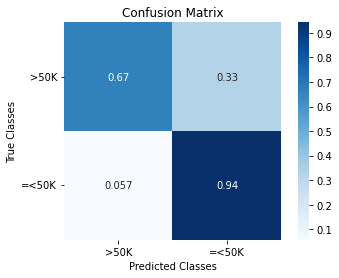

CPU times: user 839 ms, sys: 74.4 ms, total: 913 ms
Wall time: 865 ms


In [88]:
%%time
# LGBM Testing Model Evaluation
evaluate_classification(lgb_pipe, X_test, y_test, classes=target_names,
                        label='LGBModel Testing Data (Classes Included)')

## GradientBoostingClassifier

In [91]:
%%time
# Instantiate and Fit the Gradient Boosting Classifier
gradient_booster_class = GradientBoostingClassifier()

# Make a pipeline
gbc_pipe = make_pipeline(preprocessor, gradient_booster_class)

CPU times: user 238 µs, sys: 0 ns, total: 238 µs
Wall time: 256 µs


In [93]:
%%time
# fit the model
gbc_pipe.fit(X_train, y_train)

CPU times: user 10 s, sys: 136 ms, total: 10.1 s
Wall time: 9.61 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd16ebb8d10>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd16ebb8dd0>)])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: GBC Training Model Evaluation (Classes-Included)
------------------------------------------------------------
              precision    recall  f1-score   support

        >50K       0.81      0.60      0.69      5914
       =<50K       0.88      0.95      0.92     18506

    accuracy                           0.87     24420
   macro avg       0.84      0.78      0.80     24420
weighted avg       0.86      0.87      0.86     24420



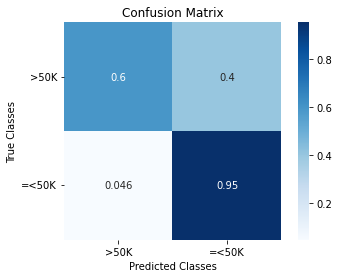

CPU times: user 1.07 s, sys: 134 ms, total: 1.2 s
Wall time: 3.1 s


In [94]:
%%time
# Evaluate the Gradient Booster Classifier
# Training Data First
evaluate_classification(gbc_pipe, X_train, y_train, classes=target_names,
                        label='GBC Training Model Evaluation (Classes-Included)')

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: GBC Testing Model Evaluation (Classes-Included)
------------------------------------------------------------
              precision    recall  f1-score   support

        >50K       0.80      0.59      0.68      1927
       =<50K       0.88      0.95      0.92      6214

    accuracy                           0.87      8141
   macro avg       0.84      0.77      0.80      8141
weighted avg       0.86      0.87      0.86      8141



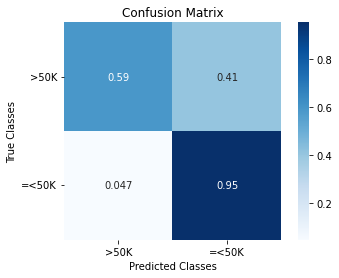

CPU times: user 480 ms, sys: 57.9 ms, total: 538 ms
Wall time: 537 ms


In [95]:
%%time
# Evaluate Testing Data Next
evaluate_classification(gbc_pipe,X_test, y_test, classes=target_names,
                        label='GBC Testing Model Evaluation (Classes-Included)')


# Tuning Gradient Boosting Models

Tree-based gradient boosting models have a LOT of hyperparameters to tune.  Here are the documentation pages for each of the 3 models you used today:

1. [XGBoost Hyperparameter Documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)
2. [LightGBM Hyperparameter Documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
3. [Scikit-learn Gradient Boosting Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Choose the model you felt performed the best when comparing multiple metrics and the runtime for fitting, and use GridSearchCV to try at least 2 different values each for 3 different hyper parameters in boosting model you chose.

See if you can create a model with an accuracy between 86 and 90.


LGBooster was the faster when evaluating, but XGB performed the best. We are going to hypertune XGB

In [96]:
%%time
xgb_pipe.get_params()

CPU times: user 667 µs, sys: 0 ns, total: 667 µs
Wall time: 678 µs


{'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd16ebb8d10>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd16ebb8dd0>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__categories': 'auto',
 'columntransformer__onehotencoder__drop': None,
 'columntransformer__onehotencoder__dtype': numpy.float64,
 'columntransformer__onehotencoder__handle_unknown': 'ignore',
 'columntransformer__onehotencoder__sparse': False,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_thre

In [107]:
# Define a dictionary of the parameters I am going to Tune
param_grid = {'xgbclassifier__n_estimatorss': range(100,200,25),
              'xgbclassifier__max_depth': range(1,6,2),
              'xgbclassifier__learning_rate': [0.1, 0.01, 0.05]}

In [108]:
%%time
#Instantiate a gridsearch with the model and the hyperparameter dictionary
grid = GridSearchCV(xgb_pipe, param_grid)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimatorss': 100}
CPU times: user 19min 55s, sys: 9.35 s, total: 20min 5s
Wall time: 16min 29s


In [109]:
# Check the optimal combinations of the hyperparameters:
best_xgbc = grid.best_estimator_
best_xgbc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd170c1c6d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd16ee12550>)])),
                ('xgbclassifier',
                 XGBClassifier(max_depth=5, n_estimatorss=100))])

# Evaluation

Evaluate your model using a classifiation report and/or a confusion matrix.  Explain in text how your model performed in terms of precision, recall, and it's ability to predict each of the two classes.  Also talk about the benefits or drawbacks of the computation time of that model.

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGBC Best Parameters Training Data (Classes Included)
------------------------------------------------------------
              precision    recall  f1-score   support

        >50K       0.82      0.64      0.72      5914
       =<50K       0.89      0.95      0.92     18506

    accuracy                           0.88     24420
   macro avg       0.85      0.80      0.82     24420
weighted avg       0.87      0.88      0.87     24420



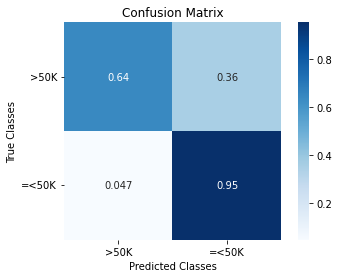

In [112]:
# Evaluate the best XGBC Training Data
evaluate_classification(best_xgbc, X_train, y_train, classes=target_names,
                                    label='XGBC Best Parameters Training Data (Classes Included)')

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XBGC Best Parameters Testing Data (Classes Included)
------------------------------------------------------------
              precision    recall  f1-score   support

        >50K       0.79      0.63      0.70      1927
       =<50K       0.89      0.95      0.92      6214

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.87      0.87      0.87      8141



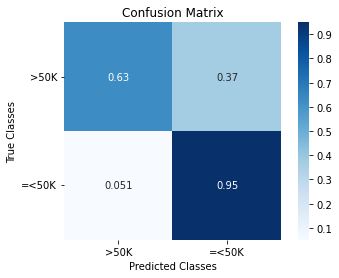

In [110]:
# Evaluate the best xgbc Testing Data
evaluate_classification(best_xgbc, X_test, y_test, classes=target_names,
                        label='XBGC Best Parameters Testing Data (Classes Included)')

With the best parameters, my model was able to perform better in precision and recall predictions of individual's who were making less than 50k. The accuracy of my model increased with the best parameters I hypertuned in the CV Grid. 

One of the benefits of the XGBC Model is it's ability to predict will less bias, however, one of the drawbacks is the amount of time it takes to complete, especially when you include the hypertuning of the parameters.

# Conclusion

In this assignment you practiced:
1. data cleaning
2. instantiating, fitting, and evaluating boosting models using multiple metrics
3. timing how long it takes a model to fit and comparing run times between multiple models
4. and choosing a final model based on multiple metrics.

